In [45]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


import numpy as np
import scipy.signal
import math


import IPython.display as ipd
%matplotlib notebook
import matplotlib.pyplot as plt
import librosa.display

#### Generators
def sine(A):
    def _sine(sr, f, t):
        return A * np.sin(2 * np.pi * f * t)

# General Saw wave
# width = 1 is rising sawtooth
# width = 0.5 is triangle
# width = 0 is falling sawtooth
def saw(A, width=1):
    def _saw(sr, f, t):
        return A * scipy.signal.sawtooth(2 * np.pi * f * t)
    return _saw

def noise(A):
    return lambda sr, f, t: np.random.random(len(t))


#### Filters

def pass_thru():
    return (lambda sr, x: x)

# Simple delay line.
# y[n] = x[n] + decay * y[n-d]
# d is in seconds
def delay(d, decay):
    def _delay(sr, x):
        delay_count = int(d * sr)
        y = np.full_like(x, 0)
        for i in range(len(x)):
            if i - delay_count < 0:
                delay_y = 0
            else:
                delay_y = y[i-delay_count]
            y[i] = x[i] + decay * delay_y
        return y
    return _delay

# Variable-delay-value delay line.
# @delay_func: delay_func(i) gives the delay value at sample point `i`
def vdelay(delay_func, decay_func):
    def _f(sr, x):
        y = np.full_like(x, 0)
        for i in range(len(x)):
            delay_count = int(delay_func(i)*sr)
            y[i] = x[i] + decay_func(i) * y[i-delay_count] if (i-delay_count) >= 0 else 0
        return y
    return _f


#### A simple player and mixer
def mix(sr, f, t, generators):
    y_out = np.full_like(t, 0)
    for g in generators:
        gen, *filters = g
        y = gen(sr, f, t)
        for filt in filters:
            y = filt(sr, y)
        y_out += y
    return y_out


def plot_dft(sr, y, title='', ylim=None):
    z = np.fft.fft(y)
    mag = np.abs(np.real(z)) / (len(y)/2)
    db = np.log10(mag) * 10
    #phi = np.angle(z) / np.pi * 180
    
    fs = np.fft.fftfreq(y.shape[-1]) * sr
    valid_n = len(fs) // 2
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    p = ax.plot(fs[:valid_n], db[:valid_n])
    plt.xlabel('f(Hz)')
    plt.ylabel('mag(dB)')
    if ylim:
        plt.ylim(*ylim)
    plt.xlim(20, 20000)
    
    plt.title(title)
    ax.set_xscale('log')

def plot_filter_transfer_function(sr, f):
    x = np.zeros(sr)
    x[0] = sr / 2
    y = f(sr, x)
    plot_dft(sr, y, title='Transfer Function(Magnitude)')
    
def easy_visualize(sr, y):
    # wave
    plt.figure()
    first_n = 1024
    plt.plot(np.arange(min(first_n, len(y))) / sr, y[:first_n])

    # dft
    Y = librosa.stft(y)
    Ydb = librosa.amplitude_to_db(abs(Y))
    plt.figure()
    librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='log')

    plot_dft(sr, y, ylim=(-50, 3))
    plt.show()


<IPython.core.display.Javascript object>


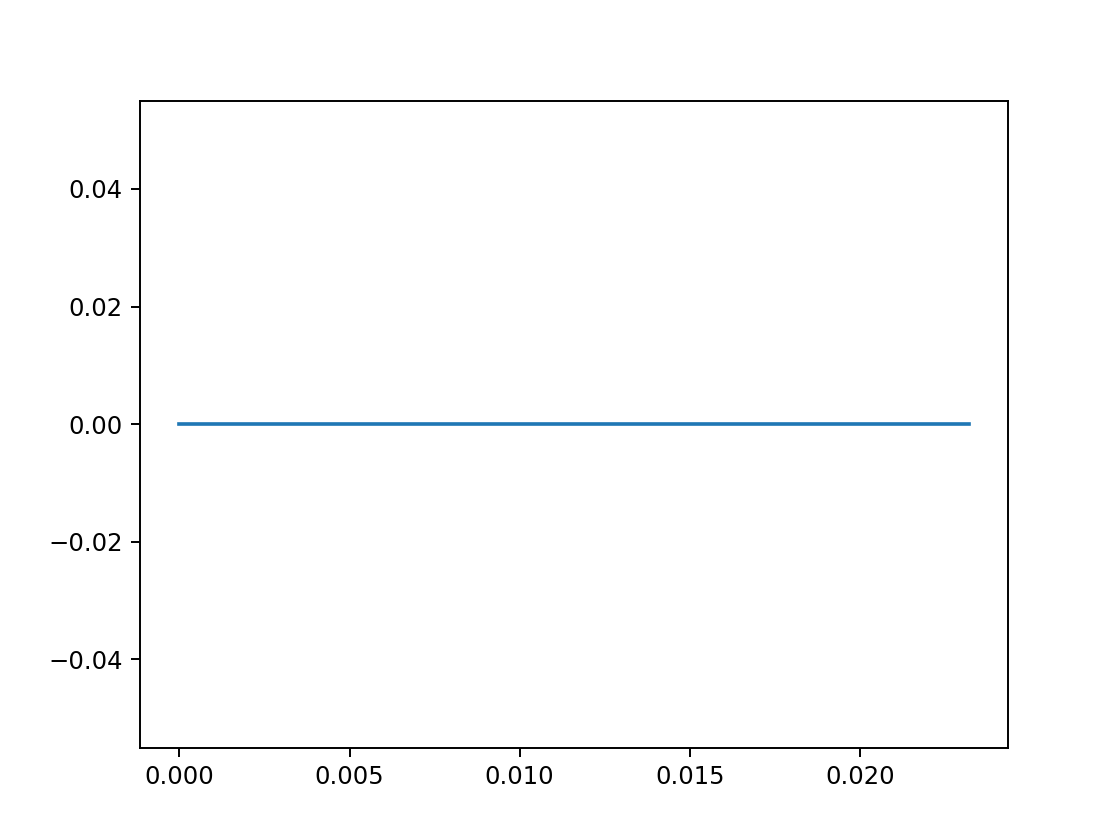

<IPython.core.display.Javascript object>


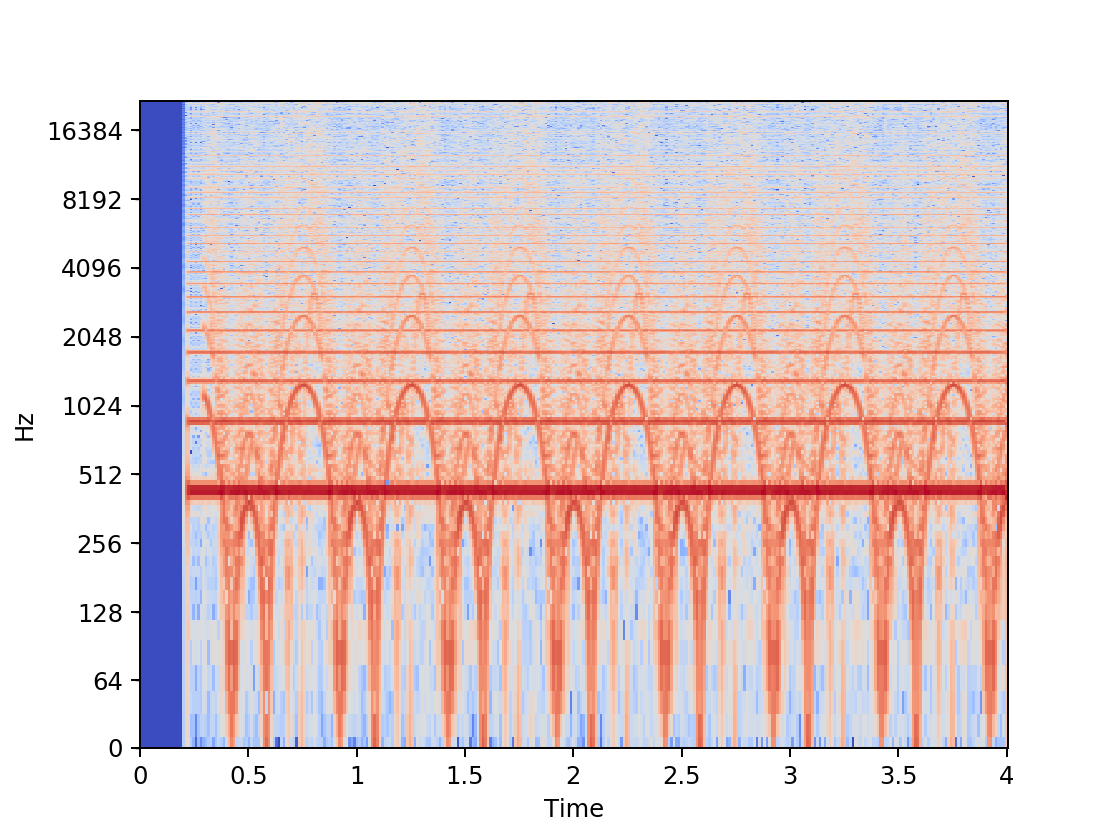

<IPython.core.display.Javascript object>


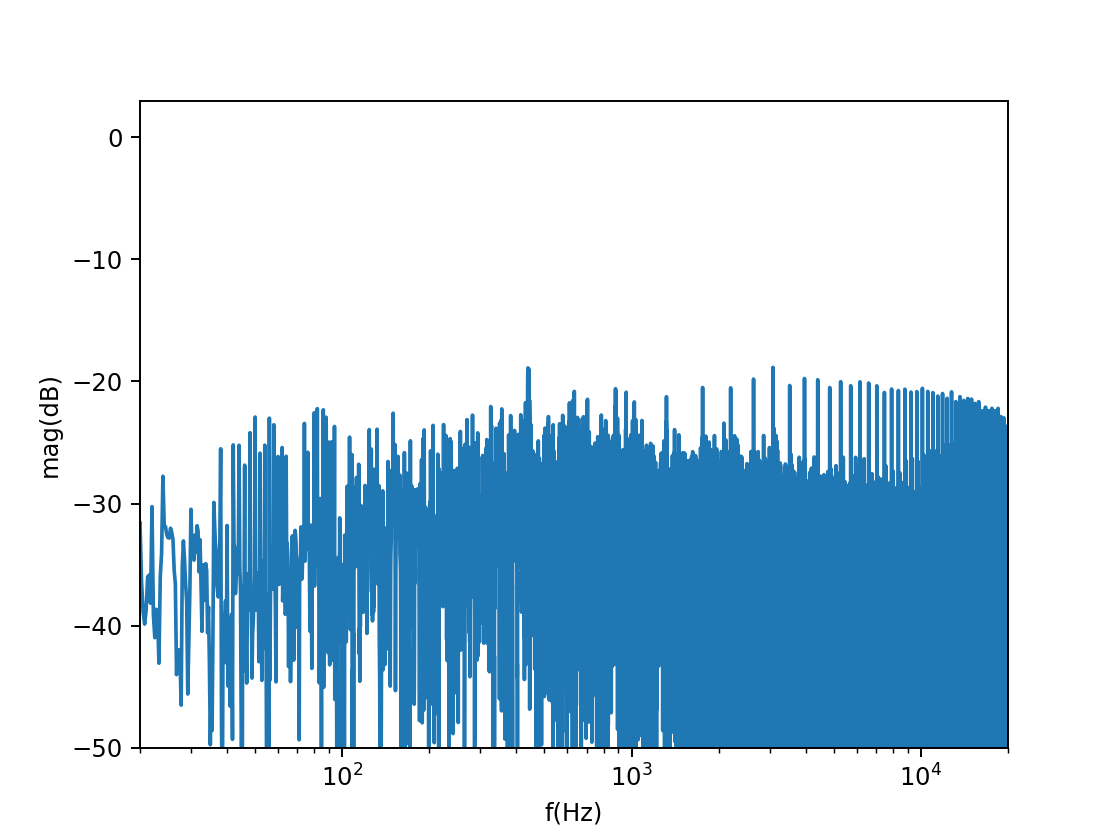

In [46]:
sr = 44100
T = 4
t = np.linspace(0, T, int(T*sr))
f = 440

generators = [
    [saw(0.5, 0.5), 
     vdelay(
         lambda i: 0.3*(math.sin(2*math.pi*2*i/sr)+1)/2, lambda i: 0.5),
     
    ]
]

y = mix(sr, f, t, generators)

easy_visualize(sr, y)
#plot_filter_transfer_function(sr, delay(1/100, 0.5))
ipd.Audio(y, rate=sr)